In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
link = 'drive/My Drive/Colab Notebooks/APS360/'
print(device)

    100% |████████████████████████████████| 591.8MB 68.3MB/s 
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
cuda:0


In [3]:
class ImageFolder(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolder, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_index = (original_tuple + (index,))
        return tuple_with_index

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    

def get_data_loader(batch_size, position="samePos"):
    
    transform = transforms.Compose([transforms.Resize((150, 250)), transforms.ToTensor()])
    
    ori_data = torchvision.datasets.ImageFolder(link+'resized_images/wide', transform = transform)
    
    if position == "diffPos":
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/diffPos/2', \
                                                transform = transform)
    else:
        data = torchvision.datasets.ImageFolder(link+'watermarked_image/samePos/2', \
                                                transform = transform)
        
        
    labeled_data = ConcatDataset(ori_data, data)
    
    trainLen = int(0.6*len(labeled_data))
    valLen = int(0.2*len(labeled_data))
    testLen = int(0.2*len(labeled_data))
    
    train_data, val_data, test_data = torch.utils.data.random_split \
    (labeled_data, [trainLen, valLen, testLen])
    
    train_data_loader = torch.utils.data.DataLoader(train_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    val_data_loader = torch.utils.data.DataLoader(val_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    test_data_loader = torch.utils.data.DataLoader(test_data, \
                                                    batch_size=batch_size,\
                                                    shuffle = False, \
                                                    num_workers=1)
    
    return train_data_loader, val_data_loader, test_data_loader

# NOTE: THIS ONLY USES ONE FOLDER!
train_data_loader, val_data_loader, test_data_loader = get_data_loader(1)
print(len(train_data_loader), len(val_data_loader), len(test_data_loader))

825 275 275


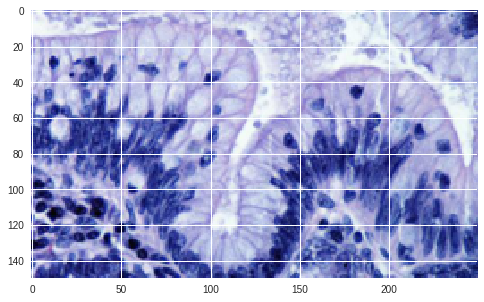

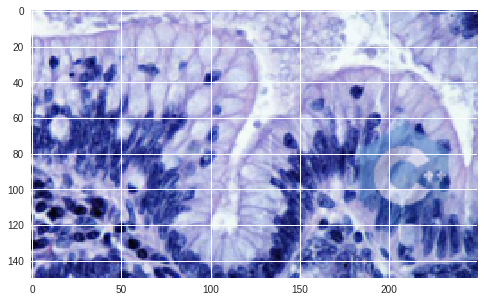

In [4]:
original, watermarked = next(iter(train_data_loader))
img_orig = torch.squeeze(original[0])
img_orig = np.transpose(img_orig, [1,2,0])
plt.imshow(img_orig)
plt.show()

img_watermarked = torch.squeeze(watermarked[0])
img_watermarked = np.transpose(img_watermarked, [1,2,0])
plt.imshow(img_watermarked)
plt.show()

In [0]:
def conv3x3(in_channels, out_channels, stride=1):
        return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         stride=stride, padding=1, bias=False)

class testResNetBlocks(nn.Module):

    def load_weights(self, layername):
        an_builtin = models.resnet18(pretrained=True) # Loads the pretrained model weights
        
        own_state = self.state_dict()
        
        for (name, layer) in an_builtin._modules.items():
            if name == layername:
                self.conv1.weight = layer[0]._modules['conv1'].weight
                self.conv2.weight = layer[0]._modules['conv2'].weight
            if layername == name+"-":
                self.conv1.weight = layer[1]._modules['conv1'].weight
                self.conv2.weight = layer[1]._modules['conv2'].weight
    
    def __init__(self, in_channels, out_channels, layername, stride=1, downsample=None):
        super(testResNetBlocks, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.load_weights(layername)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out



In [0]:
class DilatedResNet(nn.Module):
    def __init__(self, block):
        super(DilatedResNet, self).__init__()
        
        self.in_channels = 64
        self.bottleneck_channels = 16
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.layers1 = self.make_layer(block, 64, "layer1")
#         self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
#         self.layers2 = self.make_layer(block, 128, "layer2")
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, self.bottleneck_channels, 3, stride=1, padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_channels, self.bottleneck_channels, 3, stride=1, \
                               padding=2, dilation=2),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU(),
#             nn.ConvTranspose2d(16, 3, 3, stride=1, padding=2, output_padding = 1, dilation=2),
#             nn.BatchNorm2d(3),
            nn.ConvTranspose2d(self.bottleneck_channels, 3, 3, padding=1),
#             nn.ConvTranspose2d(32, 3, 3)
            nn.Sigmoid()
        )
    
    def make_layer(self, block, out_channels, layername, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, layername, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, 2):
            layers.append(block(out_channels, out_channels, layername+"-"))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layers1(x)
#         x = self.conv2(x)
#         x = self.layers2(x)
        x = self.decoder(x)
        return x

In [0]:
def get_accuracy(model, data_loader, criterion):
    total_loss, total_err, total_epoch = 0.0, 0.0, 0
    
    i = 0
    for original, watermarked in data_loader:
        ori_img, _ = original
        water_img, _ = watermarked
        ori_img = ori_img.cuda()
        water_img = water_img.cuda()
        
#         myfeatures = myfeature_model(water_img)
        recon = model(water_img)
        loss = criterion(recon, ori_img)
        
        correct = (ori_img != recon).sum().item()
        total_err += correct
        total_loss += loss.item()
        total_epoch += len(ori_img)
        i+=1
       
    
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i+1)
    
    return err, loss

In [0]:

def train(model, train_loader, val_loader, test_loader, num_epochs=5, learning_rate=1e-4, plot=False):
    
#     train_loader, val_loader, test_loader = get_data_loader(batch_size)
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_accuracies = np.zeros(num_epochs)
    val_accuracies = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_err = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    
    outputs = []
    for epoch in range(num_epochs):
        total_err = 0.0
        total_loss = 0.0
        total_epoch = 0
        
        i = 0
        for original, watermarked in train_loader:
            ori_img, _ = original
            water_img, _ = watermarked
            ori_img = ori_img.cuda()
            water_img = water_img.cuda()
            
            recon = model(water_img)
            
#             print(recon.shape, ori_img.shape)
            loss = criterion(recon, ori_img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            correct = (ori_img != recon).sum().item()
            total_err += correct
            total_loss += loss.item()
            total_epoch += len(ori_img)
            i+=1
          
        
        train_accuracies[epoch] = float(total_err) / total_epoch
        train_loss[epoch] = float(total_loss) / (i+1)
        val_accuracies[epoch], val_loss[epoch] = get_accuracy(model, val_loader, criterion)
        
        if (epoch + 1) % 5 == 0:
            print("Epoch %d; Loss %f; Val Loss %f" % (epoch+1, loss, val_loss[epoch]))
        
        outputs.append((epoch, water_img, recon))
    
    test_accuracy, test_loss = get_accuracy(model, test_loader, criterion)
    print("Final test loss: %f" % (test_loss))
    
    if plot == True:
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,num_epochs+1), train_loss, label="Train")
        plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

        plt.title("Train vs Validation Accuracies")
        plt.plot(range(1,num_epochs+1), train_accuracies, label="Train")
        plt.plot(range(1,num_epochs+1), val_accuracies, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()
    
    return outputs

In [0]:
train_loader, val_loader, test_loader = get_data_loader(32)

PATH = link+"checkpoint.pt"
# torch.save(resModel.state.dict(), PATH)
resModel = DilatedResNet(testResNetBlocks)
resModel.load_state_dict(torch.load(PATH))
resModel.cuda()

lr = 0.001
final_output = []

k = 0

for i in range(10):
    outputs = train(resModel, train_loader, val_loader, test_loader, \
                    learning_rate=lr, num_epochs=30)
    final_output.append(outputs)
    lr /= (2 * (i+1))
    
    PATH = link+"checkpoint.pt"
    torch.save(resModel.state_dict(), PATH)
    
    plt.figure(figsize=(20, 10))
    imgs = outputs[29][1]
    recon = outputs[29][2]
    
    # print original watermarked image  
    if k == 0:
        print("Original Image:")
        for j, item in enumerate(imgs):
            if j >= 2: break

            img_orig = torch.squeeze(item)
            img_orig = np.transpose(img_orig.cpu(), [1,2,0])
            plt.subplot(2, 3, j+1)
            plt.imshow(img_orig)
        
        plt.show()
        
    plt.figure(figsize=(20, 10))
    print("Reconstructed after " + str(i+1) + "x30 epochs: ")
    for j, item in enumerate(recon):
        if j >= 2: break

        img_recon = torch.squeeze(item)
        img_recon = np.transpose(img_recon.cpu().detach(), [1,2,0])
        plt.subplot(2, 3, j+1)
        plt.imshow(img_recon)
    
    plt.show()

    k+=1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 20494546.85it/s]


Epoch 5; Loss 0.000804; Val Loss 0.000761


In [0]:
PATH = link+"checkpoint_final.pt"
torch.save(resModel.state.dict(), PATH)


resModel = DilatedResNet(testResNetBlocks)
resModel.load_state_dict(torch.load(PATH))

In [0]:
for k in range(0, 50, 25):
    plt.figure(figsize=(20, 10))
    imgs = final_outputs[k][1]
    recon = final_outputs[k][2]
    
    # print original watermarked image  
    if k == 0:
        for i, item in enumerate(imgs):
            if i >= 2: break
            
            img_orig = torch.squeeze(item)
            img_orig = np.transpose(img_orig.cpu(), [1,2,0])

            plt.subplot(2, 3, i+1)
            plt.imshow(img_orig)
        
    for i, item in enumerate(recon):
        if i >= 2: break
        
        img_recon = torch.squeeze(item)
        img_recon = np.transpose(img_recon.cpu().detach(), [1,2,0])
      
        plt.subplot(2, 3, 3+i+1)
        plt.imshow(img_recon)


In [0]:
train_data_loader, val_data_loader, test_data_loader = get_data_loader(1)
original, watermarked = next(iter(test_data_loader))


img_orig = torch.squeeze(original[0])
img_orig = np.transpose(img_orig, [1,2,0])
plt.imshow(img_orig)
plt.show()

img_watermarked = torch.squeeze(watermarked[0])
img_watermarked = np.transpose(img_watermarked, [1,2,0])
plt.imshow(img_watermarked)
plt.show()

recon = resModel(watermarked[0].cuda())
recon = torch.squeeze(recon)
recon = np.transpose(recon.cpu().detach(), [1,2,0])
plt.imshow(recon)
plt.show()